# Линейный SVM "своими руками"

## Генерируем обучающую и тестовую выборку для экспериментов

In [27]:
from sklearn.model_selection import train_test_split
from sklearn import datasets

X, y = datasets.make_classification(
    n_samples=10000, n_features=20, 
    n_classes=2, n_informative=20, 
    n_redundant=0,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42
)

print(len(X), len(y))
print(len(X_train))

10000 10000
8000


In [28]:
import numpy as np

v1 = np.array([1, 1, 1])
v2 = np.array([1, 4, 2])

v3 = v1 * v2
print(v3.shape)
print(v3)

(3,)
[1 4 2]


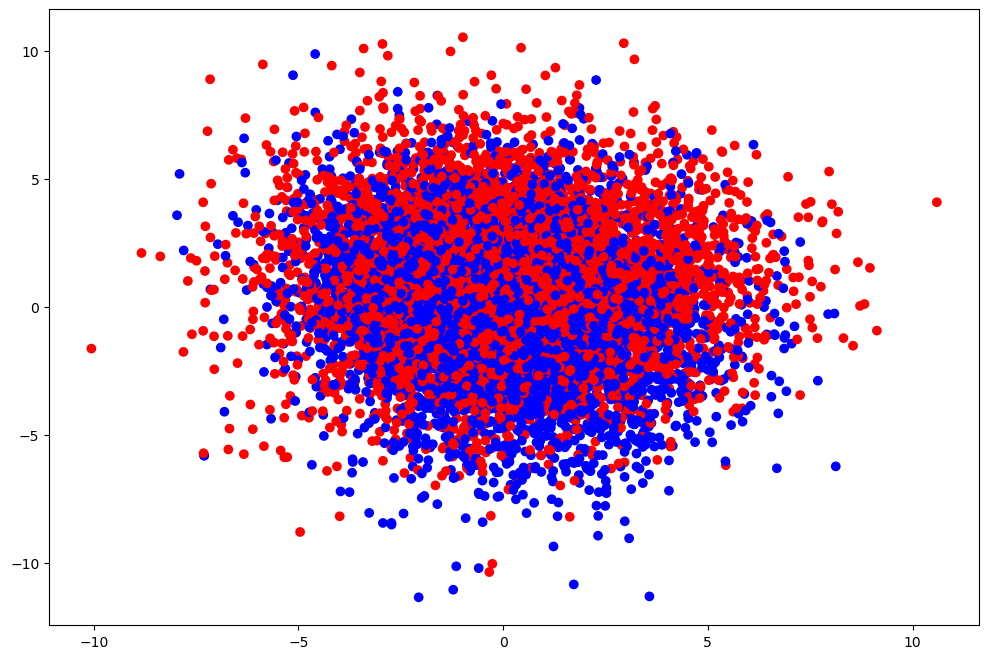

In [29]:
import matplotlib.pyplot as plt
import numpy as np

y = y.reshape(-1, 1)
colors = ("red", "blue")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y.ravel() == cl] = str(colors[i])

plt.figure(figsize=(12,8))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

## Пишем свой класс для SVM

In [30]:
import numpy as np
from random import randint
import random


np.random.seed(42)
random.seed(42)


class MySVM(object):
    def __init__(self, c=10000):
        self.C = c # regularization constant

    # f(x) = <w,x> + w_0
    def f(self, x):
        return np.dot(self.w, x) + self.w_0

    # a(x) = [f(x) > 0]
    def a(self, x):
        return 1 if self.f(x) > 0.0 else 0

    # predicting answers for X_test
    def predict(self, x_test):
        return np.array([self.a(x) for x in x_test])

    # l2-regularizator
    def reg(self):
        return 1.0 * sum(self.w ** 2) / (2.0 * self.C)

    # l2-regularizator derivative
    def der_reg(self):  #TODO
        return (2.0 * self.w) / (2.0 * self.C)
    
    # M
    def margin(self, y_i, x_i):
        return y_i * self.f(x_i)

    # hinge loss
    def loss(self, x_i, y_i):
        return max([0, 1 - self.margin(y_i, x_i)])

    # hinge loss derivative
    def der_loss(self, x_i, y_i):  #TODO
        return -1.0 if 1 - self.margin(y_i, x_i) > 0 else 0.0

    # fitting w and w_0 with SGD
    def fit(self, X_train, y_train):
        dim = len(X_train[0])
        self.w = np.random.rand(dim) # initial value for w
        self.w_0 = np.random.randn() # initial value for w_0

        # 10000 steps is OK for this example
        # another variant is to continue iterations while error is still decreasing
        for k in range(10000):

            # random example choice
            rand_index = randint(0, len(X_train) - 1) # generating random index
            x_i = X_train[rand_index]
            y_i = y_train[rand_index]

            # simple heuristic for step size
            step = max(0.99 ** k, 0.001)

            # w update
            '''ToDo: add w update with regularization'''
            self.w -= step * ((y_i * x_i * self.der_loss(x_i, y_i)) + self.der_reg())

            # w_0 update self.der_reg()
            '''ToDo: add w_0 update'''
            self.w_0 -= step * y_i * self.der_loss(x_i, y_i)

## Пробуем обучить наш классификатор и посмотреть на качество на тесте

In [31]:
model = MySVM()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

In [32]:
print(y_test, len(y_test), sum(y_test))

[1 0 1 ... 1 0 1] 2000 991


In [33]:
print(len(predictions), sum(predictions))

2000 1379


In [34]:
mysvm_res = sum(predictions == y_test) / float(len(y_test))
print(mysvm_res)

0.683


## Задания:

### - Допишите недостающие функции в MySVM (производные и обновление весов)

### - Сравните качество с sklearn LinearSVC

In [35]:
from sklearn import svm

sk_model = svm.LinearSVC(loss='hinge', dual=True, C=10000)
sk_model.fit(X_train, y_train)

predictions = sk_model.predict(X_test)

/home/vlad/miniconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [36]:
print(y_test, len(y_test), sum(y_test))

[1 0 1 ... 1 0 1] 2000 991


In [37]:
print(len(predictions), sum(predictions))

2000 1127


In [38]:
sk_svm_res = sum(predictions == y_test) / float(len(y_test))
print(sk_svm_res)

0.675


In [39]:
#assert(mysvm_res > sk_svm_res)

Итог: на данной выборке самописный svm не хуже аналога из sk_learn, хотя результаты примерно тот же

In [40]:
def stress_test():
    results = []
    for i in range(32):
        X, y = datasets.make_classification(
            n_samples=10000, n_features=20,
            n_classes=2, n_informative=20,
            n_redundant=0,
            random_state=i
        )

        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=0.2,
            random_state=42
        )

        model = MySVM()
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mysvm_res = sum(predictions == y_test) / float(len(y_test))


        sk_model = svm.LinearSVC(loss='hinge', dual=True, C=20000)
        sk_model.fit(X_train, y_train)
        predictions = sk_model.predict(X_test)
        sk_svm_res = sum(predictions == y_test) / float(len(y_test))
        
        results.append([mysvm_res, sk_svm_res])
        
    return results

In [41]:
results = stress_test()

/home/vlad/miniconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vlad/miniconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vlad/miniconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vlad/miniconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vlad/miniconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vlad/miniconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Li

In [42]:
mean_diff = 0
for pair in results:
    print(f"MySVM: {pair[0]}, SkLearnSVMres: {pair[1]}") 
    mean_diff += pair[1] - pair[0]

print(mean_diff / 32)

MySVM: 0.622, SkLearnSVMres: 0.678
MySVM: 0.7225, SkLearnSVMres: 0.7365
MySVM: 0.6655, SkLearnSVMres: 0.7225
MySVM: 0.7515, SkLearnSVMres: 0.817
MySVM: 0.6305, SkLearnSVMres: 0.732
MySVM: 0.6065, SkLearnSVMres: 0.7555
MySVM: 0.732, SkLearnSVMres: 0.7305
MySVM: 0.711, SkLearnSVMres: 0.809
MySVM: 0.6495, SkLearnSVMres: 0.6955
MySVM: 0.662, SkLearnSVMres: 0.693
MySVM: 0.714, SkLearnSVMres: 0.773
MySVM: 0.7385, SkLearnSVMres: 0.768
MySVM: 0.758, SkLearnSVMres: 0.657
MySVM: 0.6355, SkLearnSVMres: 0.7325
MySVM: 0.714, SkLearnSVMres: 0.712
MySVM: 0.749, SkLearnSVMres: 0.7865
MySVM: 0.6035, SkLearnSVMres: 0.729
MySVM: 0.7505, SkLearnSVMres: 0.777
MySVM: 0.7805, SkLearnSVMres: 0.823
MySVM: 0.756, SkLearnSVMres: 0.777
MySVM: 0.8, SkLearnSVMres: 0.8065
MySVM: 0.598, SkLearnSVMres: 0.739
MySVM: 0.769, SkLearnSVMres: 0.8455
MySVM: 0.6945, SkLearnSVMres: 0.676
MySVM: 0.654, SkLearnSVMres: 0.752
MySVM: 0.719, SkLearnSVMres: 0.676
MySVM: 0.705, SkLearnSVMres: 0.7
MySVM: 0.6615, SkLearnSVMres: 0.6585
M

В среднем отличие MySVM от LinearSVC в районе 5%